# Monte Carlo Integration: standard sampling, importance sampling, rejection sampling

Florent Leclercq,<br/>
Imperial Centre for Inference and Cosmology, Imperial College London,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from matplotlib import pyplot as plt
from math import sin,pi
np.random.seed(123456)
%matplotlib inline
plt.rcParams.update({'lines.linewidth': 2})

In [2]:
Nsamp=200

## The target pdf

In [3]:
def target_pdf(x):
    return sin(x)*sin(x)
target_pdf=np.vectorize(target_pdf)

In [4]:
a=0.
b=pi
x_arr=np.linspace(a,b,100)
f_arr=target_pdf(x_arr)

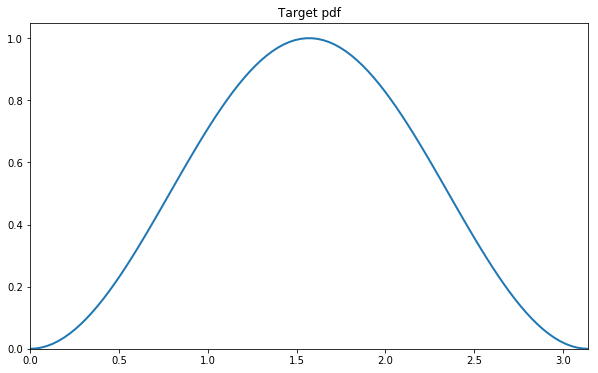

In [5]:
plt.figure(figsize=(10,6))
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr)
plt.title("Target pdf")
plt.show()

In [6]:
trueI=quad(target_pdf,a,b)[0]
trueI

1.5707963267948966

## Standard Monte Carlo integration

We directly draw samples from the target pdf.

In [7]:
randoms=np.random.uniform(a,b,Nsamp)
samples=target_pdf(randoms)

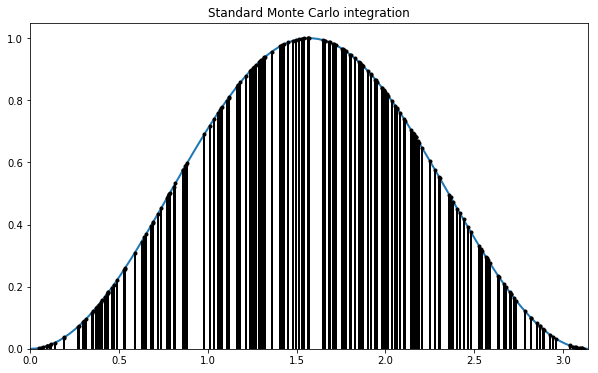

In [8]:
plt.figure(figsize=(10,6))
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr)
markerline, stemlines, baseline = plt.stem(randoms,samples,linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
plt.title("Standard Monte Carlo integration")
plt.show()

In [9]:
StandardMonteCarloI=np.sum(samples)*(b-a)/Nsamp
StandardMonteCarloI

1.660402945484072

## Importance sampling

We draw samples from a proposal pdf, designed to be as close as possible to the target pdf. We then assign each sample a weight proportional to its likelihood divided by its prior probability.

In [10]:
proposal=norm(loc=(b-a)/2,scale=0.5)
proposal_pdf=proposal.pdf

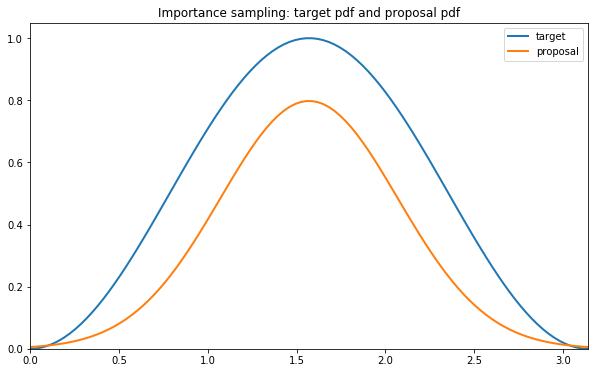

In [11]:
plt.figure(figsize=(10,6))
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,label="target")
plt.plot(x_arr,proposal_pdf(x_arr),label="proposal")
plt.title("Importance sampling: target pdf and proposal pdf")
plt.legend(loc='best')
plt.show()

In [12]:
samples=proposal.rvs(size=Nsamp)
weights=target_pdf(samples)/proposal_pdf(samples)

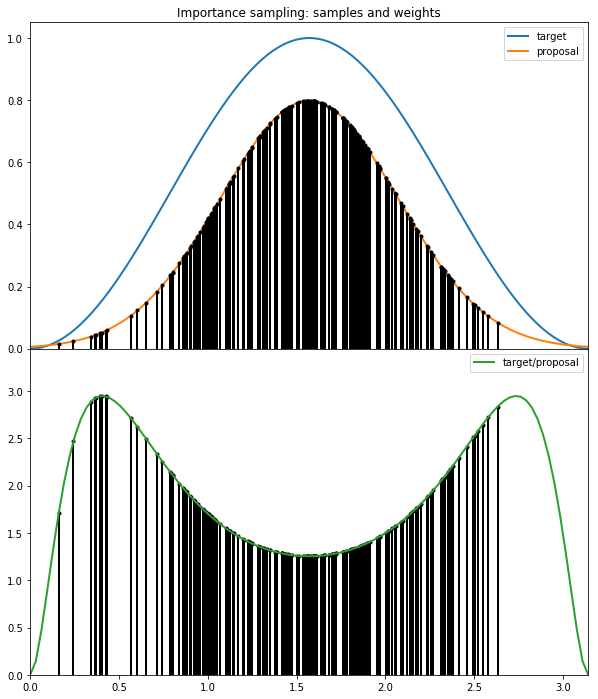

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,12))
ax1.set_xlim(a,b)
ax1.set_ylim(0,1.05)
ax1.plot(x_arr,f_arr,label="target")
ax1.plot(x_arr,proposal_pdf(x_arr),label="proposal")
markerline, stemlines, baseline = ax1.stem(samples,proposal_pdf(samples),linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
ax1.legend(loc='best')
ax1.set_title("Importance sampling: samples and weights")
markerline, stemlines, baseline = ax2.stem(samples,weights,linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
ax2.plot(x_arr,f_arr/proposal_pdf(x_arr),color='C2',label="target/proposal")
ax2.set_ylim([0,weights.max()+0.5])
ax2.legend(loc='best')
f.subplots_adjust(hspace=0)
plt.show()

In [14]:
ImportanceI=np.sum(weights)/Nsamp
ImportanceI

1.6327602442865627

## Importance resampling

A problem with importance sampling is the situation in which all but one of the weights are close to zero. To avoid with situation, we can do **importance resampling**. We draw Nresamp new samples from the current sample set with probabilities proportional to their weights. We replace the current samples with this new set, and the the current weights by 1/Nresamp (drawing according to the importance weight replaces likelihoods by frequencies).

In [15]:
Nresamp=50
normalizedweights=weights/np.sum(weights)
resamples=np.random.choice(samples, size=Nresamp, replace=True, p=normalizedweights)
reweights=1./Nresamp*np.ones(Nresamp)

Weights are then updated given their likelihood, as in the previous importance sampling step.

In [16]:
reweights*=target_pdf(resamples)/(1./Nresamp)

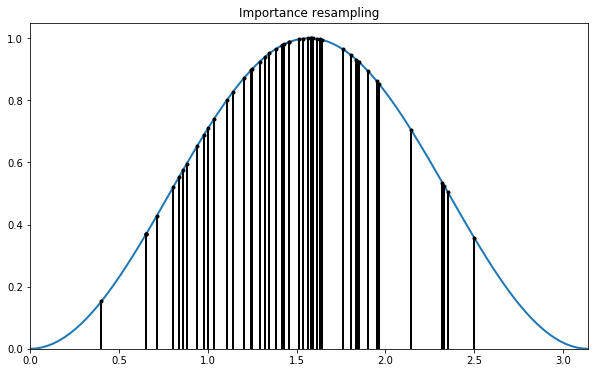

In [17]:
plt.figure(figsize=(10,6))
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr)
markerline, stemlines, baseline = plt.stem(resamples,reweights,linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
plt.title("Importance resampling")
plt.show()

In [18]:
ImportanceReI=np.sum(resamples)/Nresamp
ImportanceReI

1.4080152612723043

Iterating this procedure yields the **Sequential Importance Resampling** (SIR) algorithm, which is a simple "*particle filter*" or "*Sequential Monte Carlo*" algorithm.

## Rejection sampling

In [19]:
upperbound=1
xs=np.random.uniform(a,b,Nsamp)
ys=np.random.uniform(0,upperbound,Nsamp)

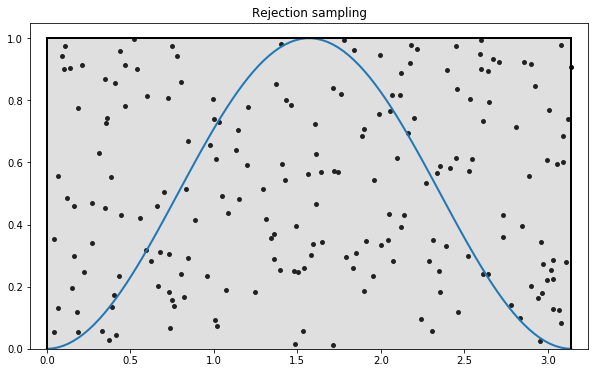

In [20]:
plt.figure(figsize=(10,6))
plt.xlim(a-0.1,b+0.1)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr)
plt.scatter(xs,ys,s=15,marker='o',color='black')
plt.fill_between(x_arr,np.zeros_like(x_arr),upperbound*np.ones_like(x_arr),color='grey',alpha=0.25)
plt.plot([a,b],[upperbound,upperbound],color='black')
plt.plot([a,a],[0,upperbound],color='black')
plt.plot([b,b],[0,upperbound],color='black')
plt.title("Rejection sampling")
plt.show()

In [21]:
accepted=np.where(ys<=target_pdf(xs))
rejected=np.where(ys>target_pdf(xs))
accepted_randoms=xs[accepted]
accepted_samples=ys[accepted]
rejected_randoms=xs[rejected]
rejected_samples=ys[rejected]

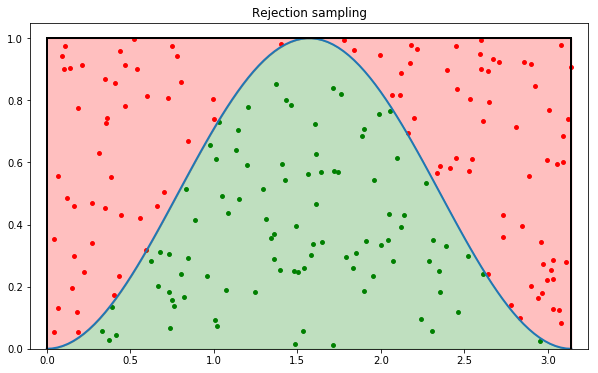

In [22]:
plt.figure(figsize=(10,6))
plt.xlim(a-0.1,b+0.1)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr)
plt.scatter(accepted_randoms,accepted_samples,s=15,marker='o',color='green')
plt.scatter(rejected_randoms,rejected_samples,s=15,marker='o',color='red')
plt.fill_between(x_arr,np.zeros_like(x_arr),f_arr,color='green',alpha=0.25)
plt.fill_between(x_arr,upperbound*np.ones_like(x_arr),f_arr,color='red',alpha=0.25)
plt.plot([a,b],[upperbound,upperbound],color='black')
plt.plot([a,a],[0,upperbound],color='black')
plt.plot([b,b],[0,upperbound],color='black')
plt.title("Rejection sampling")
plt.show()

In [23]:
fraction=float(len(accepted_samples))/Nsamp
fraction

0.46

In [24]:
fraction=float(len(accepted_samples))/Nsamp
RejectionI=fraction*upperbound*(b-a)
RejectionI

1.4451326206513049